In [3]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis, build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Superligaen']
season = '2025-2026'



In [4]:
# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'/Users/admin/Documents/dev/algobetting/infra/data/db/fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3,
    epv_weight=0

)

df.tail()

,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,poisson_epv_prob,home_idx,away_idx
2380,4801950,Superligaen,2025-08-08,FC København,AGF,8,2,0.001284,73,False,0.000670,0.0,0.003121,0.0,2,0
2381,4801950,Superligaen,2025-08-08,FC København,AGF,8,3,0.000918,73,False,0.000439,0.0,0.002230,0.0,2,0
2382,4801950,Superligaen,2025-08-08,FC København,AGF,8,4,0.000492,73,False,0.000161,0.0,0.001195,0.0,2,0
2383,4801950,Superligaen,2025-08-08,FC København,AGF,9,1,0.000429,73,False,0.000063,0.0,0.001042,0.0,2,0
2384,4801950,Superligaen,2025-08-08,FC København,AGF,9,2,0.000460,73,False,0.000089,0.0,0.001117,0.0,2,0


In [5]:
goals = df[df['is_actual'] == True]

average_goasl = (goals['home_goals'] + goals['away_goals'])
average_goasl.mean()

np.float64(3.2777777777777777)

In [7]:
df[df["match_id"] == 4801950]["weight"].sum()

np.float64(0.8641577031846427)

In [5]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 0.25),
    'Aston Villa': (0.121, 0.25),
    'Bournemouth': (0.100, 0.25),
    'Brentford': (0.079, 0.25),
    'Brighton': (0.083, 0.25),
    'Chelsea': (0.185, 0.25),
    'Crystal Palace': (0.057, 0.25),
    'Everton': (-0.108, 0.25),
    'Fulham': (-0.030, 0.25),
    'Liverpool': (0.371, 0.25),
    'Man City': (0.297, 0.25),
    'Man United': (0.011, 0.25),
    'Newcastle': (0.207, 0.25),
    'Nottm Forest': (-0.003, 0.25),
    'Tottenham': (0.121, 0.25),
    'West Ham': (-0.082, 0.25),
    'Wolves': (-0.094, 0.25),

    'Burnley': (-0.401, 0.3),
    'Leeds': (-0.103, 0.3),
    'Sunderland': (-0.553, 0.3)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 0.25),
    'Aston Villa': (-0.085, 0.25),
    'Bournemouth': (-0.001, 0.25),
    'Brentford': (-0.054, 0.25),
    'Brighton': (0.107, 0.25),
    'Chelsea': (-0.166, 0.25),
    'Crystal Palace': (0.052, 0.25),
    'Everton': (-0.085, 0.25),
    'Fulham': (-0.014, 0.25),
    'Liverpool': (-0.222, 0.25),
    'Man City': (-0.191, 0.25),
    'Man United': (-0.035, 0.25),
    'Newcastle': (-0.083, 0.25),
    'Nottm Forest': (-0.046, 0.25),
    'Tottenham': (0.163, 0.25),
    'West Ham': (0.103, 0.25),
    'Wolves': (0.137, 0.25),

    'Burnley': (0.163, 0.3),
    'Leeds': (0.163, 0.3),
    'Sunderland': (0.231, 0.3)
}



In [19]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=50000,
     tune=25000,
     manual_att_priors=None,
     manual_def_priors=None
 )

                 mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.41 0.34   -0.20     1.08       0.01     0.01    570.00   1355.00   1.01
att_str_raw[1]   0.12 0.35   -0.54     0.78       0.01     0.01    719.00   1425.00   1.01
att_str_raw[2]   0.25 0.34   -0.39     0.91       0.01     0.01    649.00   1542.00   1.01
att_str_raw[3]   0.39 0.34   -0.25     1.03       0.01     0.01    609.00   1594.00   1.01
att_str_raw[4]  -0.32 0.39   -1.05     0.42       0.01     0.01    876.00   1834.00   1.01
att_str_raw[5]  -0.17 0.38   -0.89     0.54       0.01     0.01    893.00   2043.00   1.01
att_str_raw[6]  -0.00 0.37   -0.67     0.70       0.01     0.01    704.00   1516.00   1.01
att_str_raw[7]  -0.16 0.38   -0.90     0.51       0.01     0.01    760.00   1614.00   1.01
att_str_raw[8]   0.05 0.37   -0.61     0.78       0.01     0.01    724.00   1847.00   1.01
att_str_raw[9]  -0.15 0.37   -0.79     0.60       0.01     0.01    705.00   1463.00   1.01

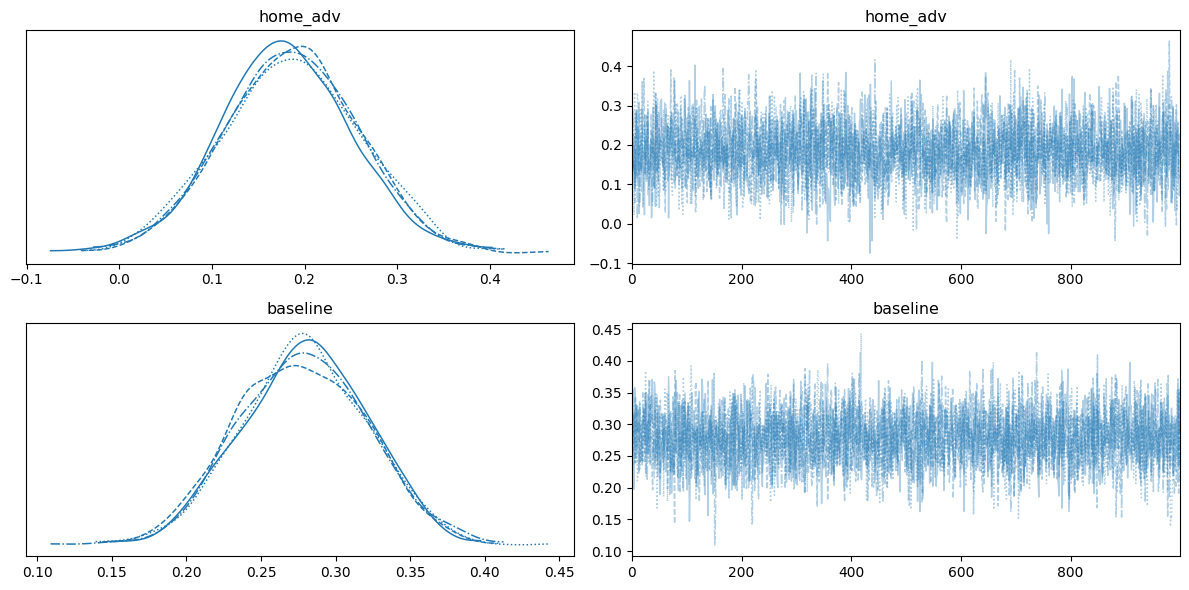

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['home_adv', 'baseline'], axes=axes)
plt.tight_layout()
plt.show()


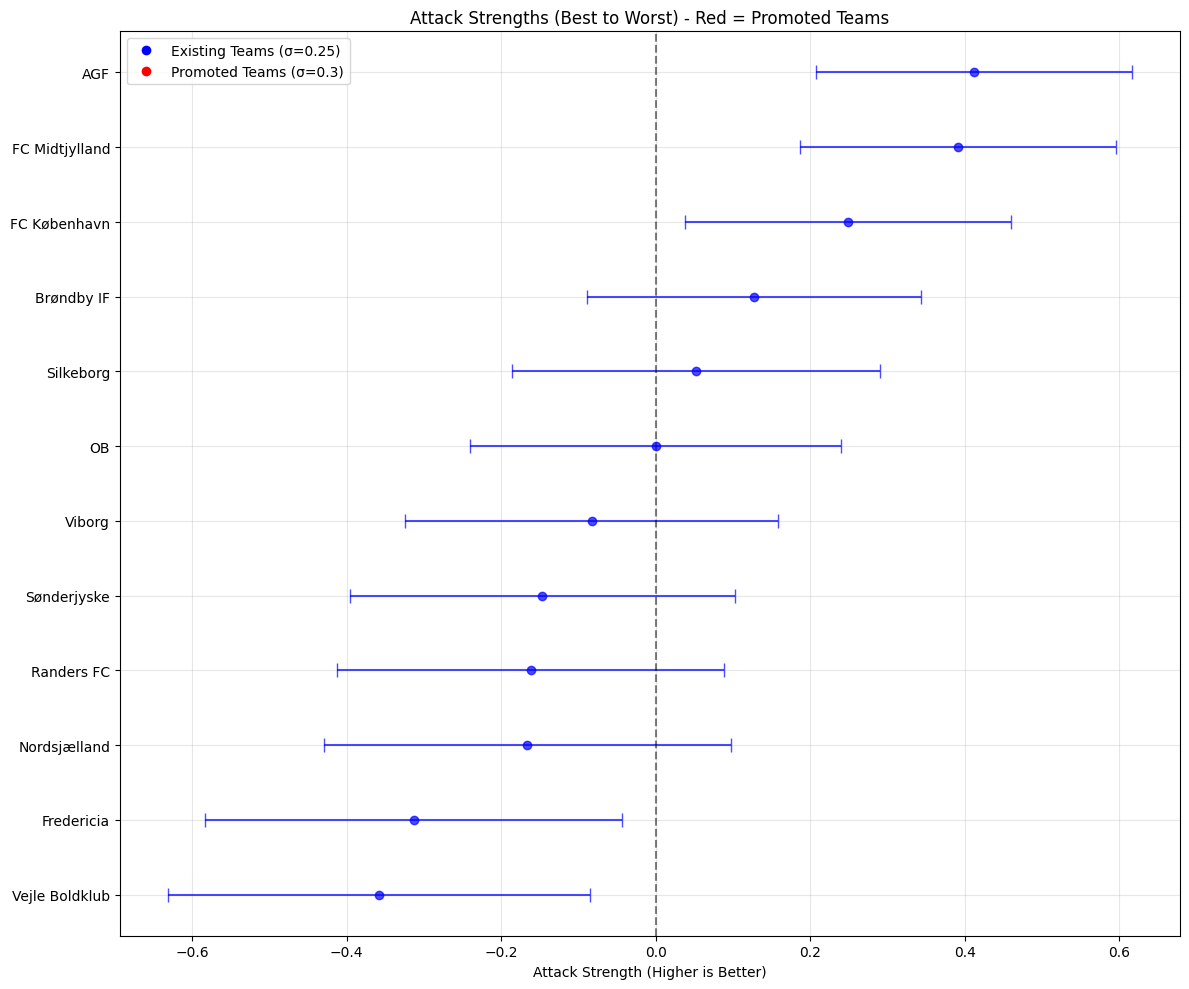

In [21]:
# Extract attack data
att_means = []
att_stds = []
att_team_names = []

for i in range(12):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    att_means.append(summary.loc[f'att_str[{i}]', 'mean'])
    att_stds.append(summary.loc[f'att_str[{i}]', 'sd'])
    att_team_names.append(team_name)

# Create DataFrame and sort by attack strength (higher is better attack)
att_data = list(zip(att_means, att_stds, att_team_names))
att_data_sorted = sorted(att_data, key=lambda x: x[0], reverse=True)  # Sort by mean (descending)

# Extract sorted data
sorted_att_means = [x[0] for x in att_data_sorted]
sorted_att_stds = [x[1] for x in att_data_sorted]
sorted_att_names = [x[2] for x in att_data_sorted]

# Create attack plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_att_means, sorted_att_stds, sorted_att_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Flip the y-position so best is at top
    ax.errorbar(mean, len(sorted_att_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_att_names)))
ax.set_yticklabels(reversed(sorted_att_names))  # Reverse the labels to match
ax.set_xlabel('Attack Strength (Higher is Better)')
ax.set_title('Attack Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

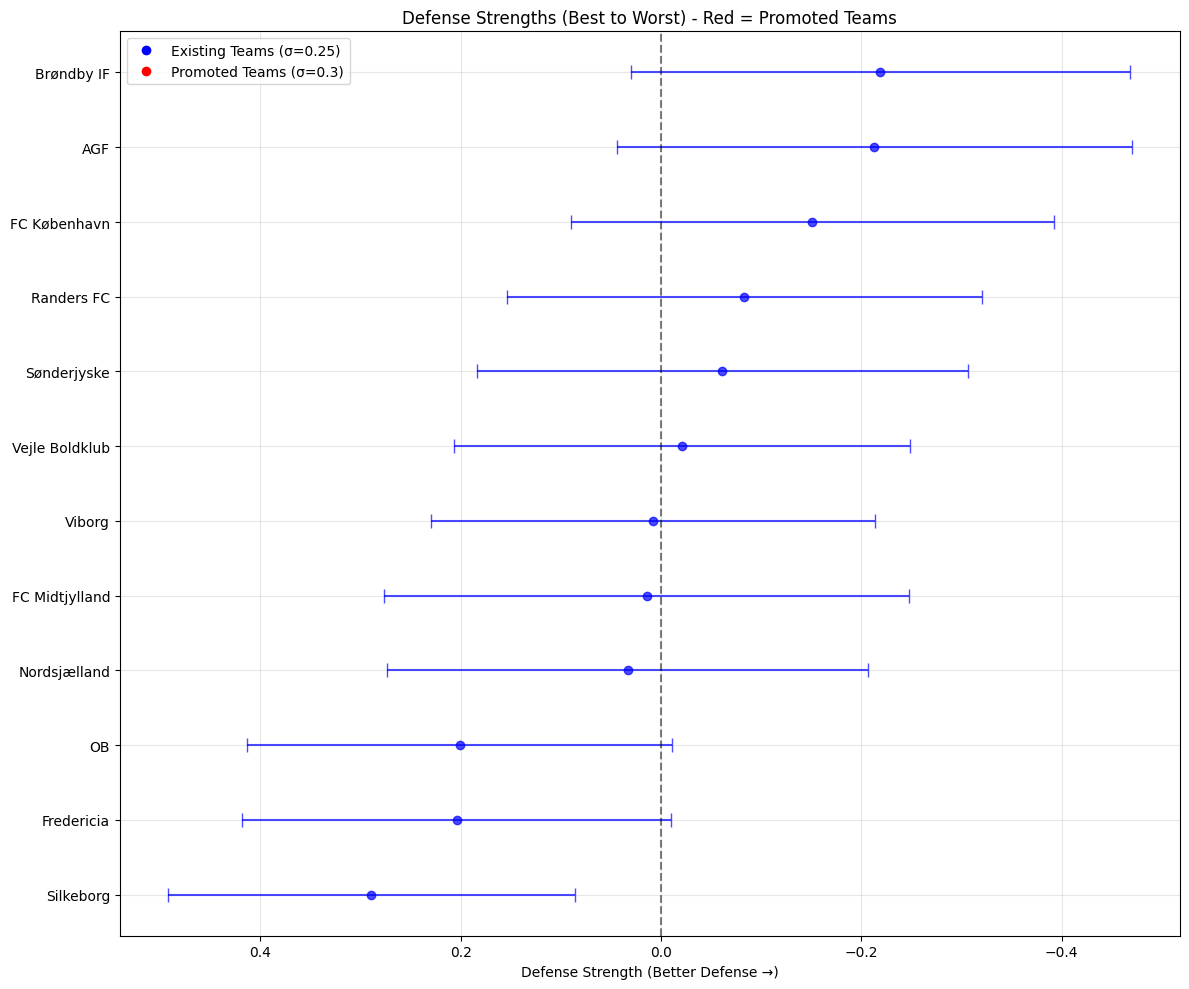

In [22]:
# Extract defense data
def_means = []
def_stds = []
def_team_names = []

for i in range(12):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    def_means.append(summary.loc[f'def_str[{i}]', 'mean'])
    def_stds.append(summary.loc[f'def_str[{i}]', 'sd'])
    def_team_names.append(team_name)

# Create DataFrame and sort by defense strength (lower is better defense)
def_data = list(zip(def_means, def_stds, def_team_names))
def_data_sorted = sorted(def_data, key=lambda x: x[0])  # Sort by mean (ascending)

# Extract sorted data
sorted_def_means = [x[0] for x in def_data_sorted]
sorted_def_stds = [x[1] for x in def_data_sorted]
sorted_def_names = [x[2] for x in def_data_sorted]

# Create defense plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_def_names))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_def_means, sorted_def_stds, sorted_def_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Reverse y-position so best defense is at top
    ax.errorbar(mean, len(sorted_def_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_def_names)))
ax.set_yticklabels(reversed(sorted_def_names))  # Reverse labels to match reversed positions
ax.set_xlabel('Defense Strength (Better Defense →)')
ax.set_title('Defense Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.invert_xaxis()  # Flip x-axis so negative is to the right

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [23]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 )  # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength)  # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df['goals_for'].sum():.2f}')
print(f'Total Goals Against: {ratings_df['goals_against'].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.278
Home advantage: 0.184

Total Goals For: 16.34
Total Goals Against: 16.05

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
           AGF       1.99           1.07              0.93
FC Midtjylland       1.95           1.34              0.61
  FC København       1.69           1.14              0.56
    Brøndby IF       1.50           1.06              0.44
    Randers FC       1.12           1.22             -0.09
   Sønderjyske       1.14           1.24             -0.10
        Viborg       1.22           1.33             -0.12
  Nordsjælland       1.12           1.36             -0.25
            OB       1.32           1.61             -0.29
Vejle Boldklub       0.92           1.29             -0.37
     Silkeborg       1.39           1.76             -0.37
    Fredericia       0.97           1.62             -0.65


In [15]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []
for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team AT HOME
    goals_for_home = np.exp(baseline_mean + home_adv_mean + att_strength + 0)  # vs avg def (0)
    
    # Goals scored vs average team AWAY
    goals_for_away = np.exp(baseline_mean + att_strength + 0)  # vs avg def (0), no home adv
    
    # Average goals for
    goals_for = (goals_for_home + goals_for_away) / 2
    
    # Goals conceded vs average team AT HOME (defending)
    goals_against_home = np.exp(baseline_mean + 0 + def_strength)  # avg att (0), no home adv for opponent
    
    # Goals conceded vs average team AWAY (defending)
    goals_against_away = np.exp(baseline_mean + home_adv_mean + 0 + def_strength)  # avg att (0) with opponent's home adv
    
    # Average goals against
    goals_against = (goals_against_home + goals_against_away) / 2
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df["goals_for"].sum():.2f}')
print(f'Total Goals Against: {ratings_df["goals_against"].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()
pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.279
Home advantage: 0.184

Total Goals For: 18.00
Total Goals Against: 17.69

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
           AGF       2.20           1.18              1.03
FC Midtjylland       2.14           1.48              0.66
  FC København       1.86           1.26              0.60
    Brøndby IF       1.65           1.16              0.48
    Randers FC       1.23           1.33             -0.10
   Sønderjyske       1.26           1.36             -0.10
        Viborg       1.34           1.46             -0.11
  Nordsjælland       1.24           1.51             -0.27
            OB       1.45           1.78             -0.33
     Silkeborg       1.54           1.94             -0.40
Vejle Boldklub       1.02           1.43             -0.41
    Fredericia       1.07           1.80             -0.73


In [16]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025,  # Replace with your actual season year
    league="Superligaen",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025
Trace saved to: model_traces/manual_priors/trace_Superligaen_2025.nc


In [13]:
import numpy as np
import pandas as pd

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals for each posterior sample
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    )
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    )
    
    # Generate actual goal predictions using Poisson
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

# Predict multiple matches
matches = [
    ('Arsenal', 'Crystal Palace'),
    ('Aston Villa', 'Man City'),
    ('Bournemouth', 'Nottm Forest'),
    ('Brentford', 'Liverpool'),
    ('Chelsea', 'Sunderland'),
    ('Everton', 'Tottenham'),
    ('Leeds', 'West Ham'),
    ('Man United', 'Brighton'),
    ('Newcastle', 'Fulham'),
    ('Wolves', 'Burnley')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Arsenal         vs Crystal Palace : 1.98-0.98 (60%-21%-19%) Total: 3.0
Aston Villa     vs Man City       : 1.17-1.65 (28%-24%-48%) Total: 2.8
Bournemouth     vs Nottm Forest   : 1.85-1.19 (51%-23%-26%) Total: 3.0
Brentford       vs Liverpool      : 1.35-1.81 (29%-22%-48%) Total: 3.2
Chelsea         vs Sunderland     : 2.13-0.71 (69%-19%-12%) Total: 2.8
Everton         vs Tottenham      : 1.44-1.26 (41%-26%-33%) Total: 2.7
Leeds           vs West Ham       : 1.59-1.18 (47%-24%-30%) Total: 2.8
Man United      vs Brighton       : 1.76-1.58 (43%-21%-36%) Total: 3.3
Newcastle       vs Fulham         : 1.60-0.99 (50%-25%-24%) Total: 2.6
Wolves          vs Burnley        : 1.68-1.09 (51%-24%-26%) Total: 2.8
TOTAL GOALS ACROSS ALL MATCHES: 29.00
AVERAGE GOALS PER MATCH: 2.90


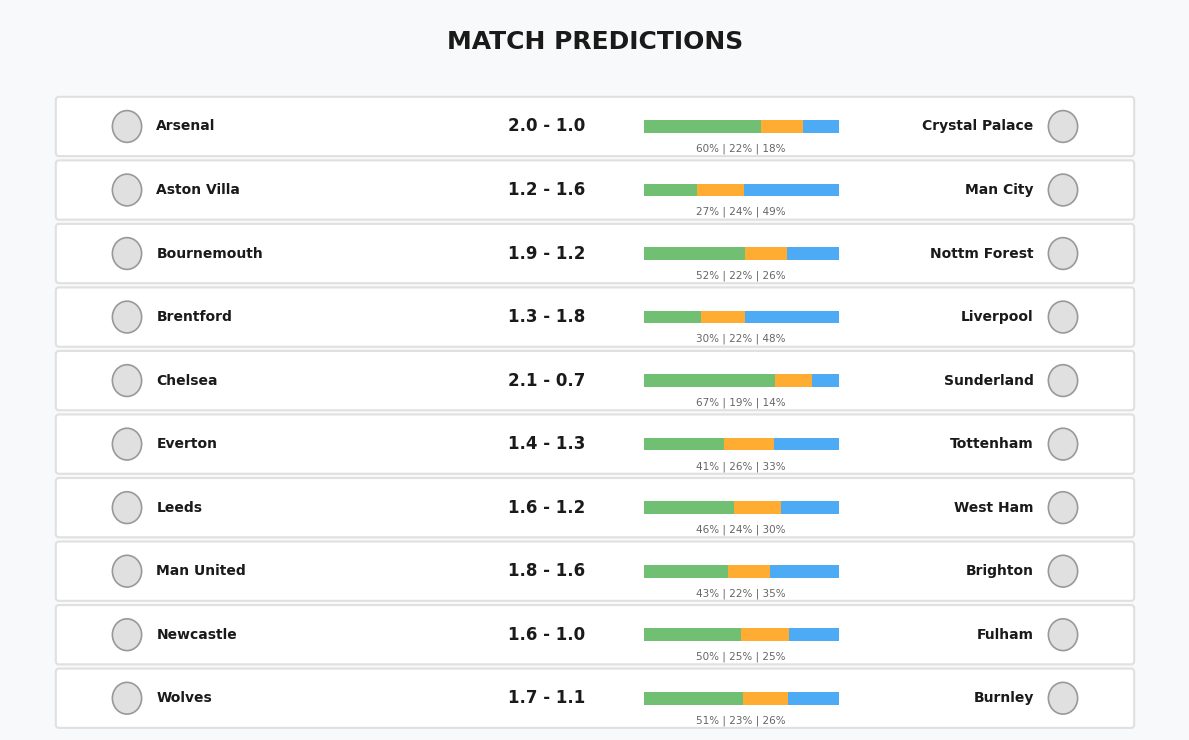

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle
import numpy as np

def visualize_predictions_compact(matches, trace, team_mapping):
    """
    Create a compact table-style visualization of match predictions
    """
    # Get predictions for all matches
    predictions = []
    for home, away in matches:
        result = predict_match(home, away, trace, team_mapping)
        predictions.append(result)
    
    # Set up the figure with fixed row height
    row_height = 0.6
    fig_height = len(matches) * row_height + 1.5
    fig, ax = plt.subplots(figsize=(12, fig_height))
    fig.patch.set_facecolor('#f8f9fa')
    ax.set_facecolor('#ffffff')
    
    # Remove axes
    ax.axis('off')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, len(matches) * row_height + 0.8)
    
    # Add title
    title_y = len(matches) * row_height + 0.5
    ax.text(6, title_y, 'MATCH PREDICTIONS', 
            ha='center', va='center', fontsize=18, fontweight='bold',
            color='#1a1a1a')
    
    # Colors
    home_color = '#4CAF50'
    away_color = '#2196F3'
    draw_color = '#FF9800'
    text_color = '#1a1a1a'
    light_gray = '#e0e0e0'
    
    # Draw each match
    for idx, pred in enumerate(predictions):
        y_pos = (len(matches) - idx - 0.5) * row_height
        
        # Background box for each match
        box = FancyBboxPatch((0.5, y_pos - 0.25), 11, 0.5,
                             boxstyle="round,pad=0.03", 
                             edgecolor=light_gray, facecolor='white',
                             linewidth=1.5, zorder=1)
        ax.add_patch(box)
        
        # Home team (left side)
        home_circle = Circle((1.2, y_pos), 0.15, color=light_gray, ec='#999', 
                            linewidth=1.2, zorder=2)
        ax.add_patch(home_circle)
        ax.text(1.5, y_pos, pred['home_team'], 
                ha='left', va='center', fontsize=10, fontweight='600',
                color=text_color)
        
        # Score prediction (center-left)
        score_text = f"{pred['home_goals_expected']:.1f} - {pred['away_goals_expected']:.1f}"
        ax.text(5.5, y_pos, score_text,
                ha='center', va='center', fontsize=12, fontweight='bold',
                color=text_color)
        
        # Away team (right side)
        away_circle = Circle((10.8, y_pos), 0.15, color=light_gray, ec='#999', 
                            linewidth=1.2, zorder=2)
        ax.add_patch(away_circle)
        ax.text(10.5, y_pos, pred['away_team'], 
                ha='right', va='center', fontsize=10, fontweight='600',
                color=text_color)
        
        # Probability bars (center-right)
        bar_y = y_pos - 0.06
        bar_width = 2.0
        bar_height = 0.12
        bar_x_start = 6.5
        
        total_prob = pred['home_win_prob'] + pred['draw_prob'] + pred['away_win_prob']
        
        # Home win probability
        home_width = bar_width * (pred['home_win_prob'] / total_prob)
        if home_width > 0:
            ax.add_patch(plt.Rectangle((bar_x_start, bar_y), home_width, bar_height,
                                      facecolor=home_color, alpha=0.8, zorder=2))
        
        # Draw probability
        draw_width = bar_width * (pred['draw_prob'] / total_prob)
        if draw_width > 0:
            ax.add_patch(plt.Rectangle((bar_x_start + home_width, bar_y), 
                                      draw_width, bar_height,
                                      facecolor=draw_color, alpha=0.8, zorder=2))
        
        # Away win probability
        away_width = bar_width * (pred['away_win_prob'] / total_prob)
        if away_width > 0:
            ax.add_patch(plt.Rectangle((bar_x_start + home_width + draw_width, bar_y), 
                                      away_width, bar_height,
                                      facecolor=away_color, alpha=0.8, zorder=2))
        
        # Probability percentages below bar
        prob_text = f"{pred['home_win_prob']:.0%} | {pred['draw_prob']:.0%} | {pred['away_win_prob']:.0%}"
        ax.text(bar_x_start + bar_width/2, bar_y - 0.10, prob_text,
                ha='center', va='top', fontsize=7.5, color='#666')
    
    plt.tight_layout()
    return fig

# Create the visualization
fig = visualize_predictions_compact(matches, trace, team_mapping)
plt.savefig('match_predictions_compact.png', dpi=300, bbox_inches='tight', 
            facecolor='#f8f9fa')
plt.show()

In [17]:
def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1  # Start position from 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

def simulate_full_season(trace, team_mapping, df_actual):
    """Simulate a full season using actual results where available and simulating unplayed matches"""
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,
        'xg_against': 0.0,
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Create a set of played matches for quick lookup
    # Assuming df_actual has columns: home_team, away_team, is_actual
    played_matches = set()
    if df_actual is not None and 'is_actual' in df_actual.columns:
        actual_games = df_actual[df_actual['is_actual'] == True]
        for _, row in actual_games.iterrows():
            played_matches.add((row['home_team'], row['away_team']))
    
    # Generate all possible matches
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                
                # Check if this match has already been played
                if (home_team, away_team) in played_matches:
                    # Use actual result
                    actual_match = df_actual[
                        (df_actual['home_team'] == home_team) & 
                        (df_actual['away_team'] == away_team) & 
                        (df_actual['is_actual'] == True)
                    ].iloc[0]
                    
                    home_goals = int(actual_match['home_goals'])
                    away_goals = int(actual_match['away_goals'])
                    
                    # Get xG if available in the dataframe, otherwise predict
                    if 'home_xg' in actual_match and 'away_xg' in actual_match:
                        home_xg = actual_match['home_xg']
                        away_xg = actual_match['away_xg']
                    else:
                        result = predict_match(home_team, away_team, trace, team_mapping)
                        home_xg = result['home_goals_expected']
                        away_xg = result['away_goals_expected']
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': home_xg,
                        'away_expected': away_xg,
                        'is_actual': True
                    }
                else:
                    # Simulate the match
                    result = predict_match(home_team, away_team, trace, team_mapping)
                    
                    home_goals = np.random.poisson(result['home_goals_expected'])
                    away_goals = np.random.poisson(result['away_goals_expected'])
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': result['home_goals_expected'],
                        'away_expected': result['away_goals_expected'],
                        'is_actual': False
                    }
                
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += match_result['home_expected']
                league_table[home_team]['xg_against'] += match_result['away_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += match_result['away_expected']
                league_table[away_team]['xg_against'] += match_result['home_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

# Usage:
print("Simulating full season with actual results...")
league_table, all_matches = simulate_full_season(trace, team_mapping, df)  # Pass your df here
final_table = print_league_table(league_table)

# Additional statistics showing actual vs simulated
actual_matches = sum(1 for match in all_matches if match.get('is_actual', False))
simulated_matches = len(all_matches) - actual_matches
total_goals = sum([match['home_goals'] + match['away_goals'] for match in all_matches])

print(f"\nSEASON STATISTICS:")
print(f"Actual matches: {actual_matches}")
print(f"Simulated matches: {simulated_matches}")
print(f"Total matches: {len(all_matches)}")
print(f"Total goals: {total_goals}")
print(f"Average goals per match: {total_goals/len(all_matches):.2f}")


Simulating full season with actual results...


NameError: name 'predict_match' is not defined

In [15]:
import numpy as np
import pandas as pd
from collections import defaultdict

def run_multiple_seasons(n_simulations, trace, team_mapping, df_actual):
    """Run multiple season simulations using actual results and return averaged results"""
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics - now including xG
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}  # 20 positions
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation with actual results
        league_table, _ = simulate_full_season(trace, team_mapping, df_actual)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1  # Position 1-20
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            # Track position frequency
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': stats['total_xg_for'] / n_simulations,
            'avg_xg_against': stats['total_xg_against'] / n_simulations,
            'avg_position': stats['position_sum'] / n_simulations
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

# Run simulations with actual results
n_sims = 1000
print(f"Using actual results and simulating remaining fixtures...")
avg_table, position_freq = run_multiple_seasons(n_sims, trace, team_mapping, df)

# Count actual matches to calculate correct games per season
actual_matches_per_team = df[df['is_actual'] == True].groupby('home_team').size().mean() + \
                           df[df['is_actual'] == True].groupby('away_team').size().mean()
games_per_season = 38  # Total games in a full season

# Print averaged league table with per-game stats
print("\n" + "="*150)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*150)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/G':>6} {'GA/G':>6} {'GD/G':>6} {'xGF/G':>7} {'xGA/G':>7} {'xGD/G':>7} {'Avg Pos':>8}")
print("-"*150)

for pos, row in avg_table.iterrows():
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f}")

# Additional info about the simulation
print("\n" + "="*150)
print("SIMULATION INFO:")
actual_match_count = df[df['is_actual'] == True].shape[0]
total_season_matches = len(teams) * (len(teams) - 1)  # Each team plays every other team twice
simulated_match_count = total_season_matches - actual_match_count
print(f"Actual matches used: {actual_match_count}")
print(f"Matches simulated per iteration: {simulated_match_count}")
print(f"Total simulated matches across all simulations: {simulated_match_count * n_sims:,}")
print("="*150)

Using actual results and simulating remaining fixtures...
Running 1000 season simulations...
Completed 1000 simulations...

AVERAGE LEAGUE TABLE OVER 1,000 SIMULATIONS (Per Game Stats)
Pos Team              Pts     W     D     L   GF/G   GA/G   GD/G   xGF/G   xGA/G   xGD/G  Avg Pos
------------------------------------------------------------------------------------------------------------------------------------------------------
  1 Arsenal          79.4  23.9   7.7   6.4   1.85   0.77  +1.08    1.82    0.89   +0.94     1.61
  2 Liverpool        71.9  21.8   6.4   9.8   1.93   1.20  +0.73    1.95    1.18   +0.77     3.12
  3 Man City         71.6  21.3   7.6   9.1   1.94   1.07  +0.88    1.91    1.15   +0.76     3.08
  4 Chelsea          67.3  19.6   8.6   9.8   1.86   1.18  +0.67    1.84    1.21   +0.62     4.25
  5 Bournemouth      58.7  16.3   9.9  11.8   1.59   1.43  +0.16    1.54    1.47   +0.07     7.63
  6 Newcastle        58.5  16.1  10.2  11.7   1.43   1.11  +0.32    1.57    

NameError: name 'teams' is not defined